# Figure 4

In [15]:
import pickle
import pandas as pd
import numpy as np
from zebrafish_ms2_paper.trace_analysis import extract_traces, binarize_trace, predict_protein_for_all_nuclei
from zebrafish_ms2_paper.ap_analysis import (bin_aps, get_ap_for_somites, 
                        filter_spots_by_distance_from_somite, 
                        filter_spots_by_perp_distance_from_ap_axis, 
                        get_ap_for_spots,
                        get_microns_between_ap_bins,
                        get_ap_um,
                        bin_aps_um)
import matplotlib.pyplot as plt
from matplotlib import rc

In [16]:
"""specify the paths to the required datasets"""
path_to_dataset1 = r'/home/brandon/Documents/somitogenesis/paper_1/supplemental_data_files/Supplemental_Data_File_1_Dataset_1_NEW.pkl'#"ADD_PATH_TO_DATASET1_HERE"
path_to_non_blank_timepoints = r'/media/brandon/Data1/Somitogenesis/Dorado/non_blank_timepoints_full.pkl'#"ADD_PATH_TO_NON_BLANK_TIMEPOINTS_HERE"
path_to_ap_axis = r'/media/brandon/Data1/Somitogenesis/Dorado/ap.pkl'#"ADD_PATH_TO_AP_AXIS_HERE"
path_to_nuclear_tracks = r'/media/brandon/Data1/Somitogenesis/Dorado/tracks_corrected.csv'#"ADD_PATH_TO_NUCLEAR_TRACKS_HERE"
path_to_somites = r'/media/brandon/Data1/Somitogenesis/Dorado/last_formed_somite_v2.pkl'

## Figure 4C, D
her1-MS2 and predicted protein kymographs

In [17]:
"""a function for stretching the aspect ratio of the kymograph for display purposes"""
def stretch_kymograph(k, factor):
    """stretch kymograph along horizontal axix by factor"""
    factor = int(factor)
    stretched = np.zeros((k.shape[0], k.shape[1] * factor))
    for i in range(k.shape[1]):
        stretched[:, factor * i : factor * (i+1)] = np.repeat(np.expand_dims(k[:, i], axis=1), factor, axis=1)
        
    return stretched


In [18]:
"""load all of the various datasets you need"""
full_df = pd.read_pickle(path_to_dataset1)

# coordinates of the ap axis
with open(path_to_ap_axis, 'rb') as f:
    ap = pickle.load(f)

if 'ap' not in full_df.keys():
    full_df = get_ap_for_spots(full_df, ap)

# nuclear locations
tracks = pd.read_csv(path_to_nuclear_tracks)

# correct time stamps
with open(path_to_non_blank_timepoints,'rb') as fp:
    non_blank_timepoints = pickle.load(fp)

# location of last formed somite
with open(path_to_somites, 'rb') as f:
    last_formed_somite = pickle.load(f)
somites = pd.DataFrame(last_formed_somite, columns=['t', 'z', 'y', 'x'])
somites = somites[somites.t <= 161]
somites = get_ap_for_somites(somites, ap)

In [19]:
# apply some additional filtering to the dataframe
filtered_df = filter_spots_by_distance_from_somite(full_df, somites, distance_thresh=-8)
filtered_df, dists = filter_spots_by_perp_distance_from_ap_axis(filtered_df, ap, dz=0, distance_thresh=50)
max_sigma= np.max(filtered_df[['sigma_x', 'sigma_y', 'sigma_z']], axis=1).values
filtered_df = filtered_df[np.array([max_sigma < 3.0] and [max_sigma > 0.5]).flatten()]
filtered_df = filtered_df[filtered_df.offset < 700]

# compute actual microns along ap axis. use this for binning
filtered_df = get_ap_um(filtered_df, ap, dz=1, dyx=0.485)

# keep only the somite positions where there is a jump to a newly formed somite
somite_shifts = np.concatenate((np.expand_dims(np.array(0), axis=0), np.diff(somites.ap)))
somites = somites[somite_shifts > 5]

# protein kymograph
protein_df = predict_protein_for_all_nuclei(filtered_df, tracks, method='gauss3d_dog')
protein_df = get_ap_for_spots(protein_df, ap)
protein_df = get_ap_um(protein_df, ap, dz=1, dyx=0.485)

bins = np.linspace(0, 521, 100)
protein_df = bin_aps_um(protein_df, bins)
filtered_df = bin_aps_um(filtered_df, bins)

df = protein_df.get(['t','pred_protein','binned_ap'])

kymograph_df = df.groupby(['t','binned_ap']).mean()#sum()
kymograph_df.columns = ['total_fp']
kymograph_df = kymograph_df.reset_index()

t_arr = np.arange(0, 160)

ap_arr = np.arange(0, len(bins))
kymograph = np.zeros((len(t_arr), len(ap_arr)))
for j in range(len(t_arr)):
    for i in range(len(ap_arr)):
        sub_df = kymograph_df[kymograph_df.t == t_arr[j]]
        sub_df = sub_df[sub_df.binned_ap == ap_arr[i]]
        if len(sub_df) > 0:
            kymograph[j, i] = sub_df.total_fp
        
kymograph_protein = kymograph

# ms2
df = filtered_df.get(['t','gauss3d_dog','binned_ap'])

kymograph_df = df.groupby(['t','binned_ap']).mean()#sum()
kymograph_df.columns = ['total_ms2']
kymograph_df = kymograph_df.reset_index()

ap_arr = np.arange(0, len(bins))#np.arange(np.min(kymograph_df.binned_ap), np.max(kymograph_df.binned_ap))
kymograph = np.zeros((len(t_arr), len(ap_arr)))
for j in range(len(t_arr)):
    for i in range(len(ap_arr)):
        sub_df = kymograph_df[kymograph_df.t == t_arr[j]]
        sub_df = sub_df[sub_df.binned_ap == ap_arr[i]]
        if len(sub_df) > 0:
            kymograph[j, i] = sub_df.total_ms2
        
kymograph_ms2 = kymograph

somites = get_ap_um(somites, ap, dz=1, dyx=0.485)
somite_aps = bin_aps_um(somites, bins)


/home/brandon/Documents/Code/zebrafish-ms2-paper/zebrafish_ms2_paper/trace_analysis.py:285: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  protein_df = pd.concat((protein_df, tmp_df), axis=0)
/tmp/ipykernel_1235717/3620832884.py:39: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  kymograph[j, i] = sub_df.total_fp
/tmp/ipykernel_1235717/3620832884.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  kymograph[j, i] = sub_df.total_ms2


<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:53: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1235717/2555020964.py:32: SyntaxWarning: invalid escape sequence '\m'
  ax1.set_xlabel('ap position ($\mu$m)', fontsize=24)
/tmp/ipykernel_1235717/2555020964.py:53: SyntaxWarning: invalid escape sequence '\m'
  ax2.set_xlabel('ap position ($\mu$m)', fontsize=24)


(38.0, 180.0)

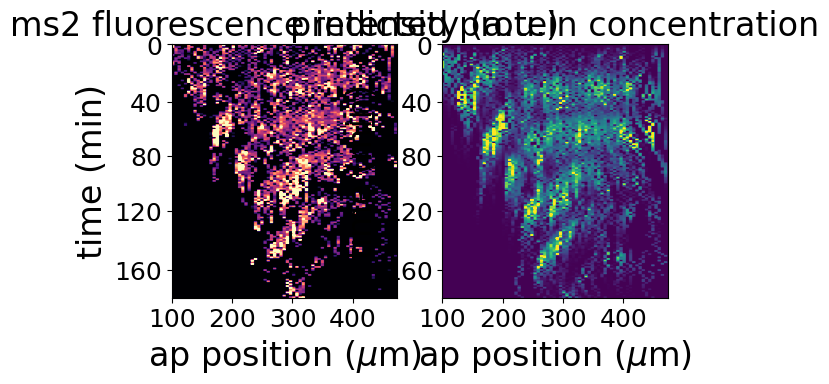

In [37]:
"""plot kymograph as an image"""
factor = 2
microns_per_bin = np.mean(get_microns_between_ap_bins(ap, dz=1, dyx=0.485))
microns = bins

fig, (ax1, ax2) = plt.subplots(1, 2)

# ms2
kymograph = kymograph_ms2
stretched = stretch_kymograph(kymograph, factor=factor)
cmap = 'magma'

ax1.imshow(stretched, vmin=0, vmax=0.25 * np.max(kymograph), cmap=cmap)
ax = plt.gca()
# can optionally plot location of last formed somite
# ax1.plot(somite_aps.binned_ap * factor, somite_aps.t, marker='o', 
#           markersize=12, markerfacecolor='none', markeredgecolor='r', 
#           color='none', markeredgewidth=2)

microns_to_label = [0, 100, 200, 300, 400, 500]
xticks = np.zeros_like(microns_to_label)
for i, m in enumerate(microns_to_label):
    xticks[i] = factor * np.where(np.abs(microns - m) == np.min(np.abs(microns - m)))[0][0]
ax1.set_xticks(xticks, labels=microns_to_label, fontsize=18)

times_to_label = [0, 40, 80, 120, 160]
yticks = np.zeros_like(times_to_label)
for i, t in enumerate(times_to_label):
    yticks[i] = np.where(np.abs(non_blank_timepoints - t) == np.min(np.abs(non_blank_timepoints - t)))[0][0]
ax1.set_yticks(yticks, labels=times_to_label, fontsize=18)

ax1.set_xlabel('ap position ($\mu$m)', fontsize=24)
ax1.set_ylabel('time (min)', fontsize=24)
ax1.set_title('ms2 fluorescence intensity (a.u.)', fontsize=24)
ax1.set_xlim([19 * factor, 90 * factor])


# protein
cmap = 'viridis'

kymograph = kymograph_protein
stretched = stretch_kymograph(kymograph, factor=factor)

ax2.imshow(stretched, vmin=0, vmax=0.35 * np.max(kymograph), cmap=cmap)

# can optionally plot location of last formed somite
#ax2.plot(somite_aps.binned_ap * factor, somite_aps.t, marker='o', 
#          markersize=12, markerfacecolor='none', markeredgecolor='r', 
#          color='none', markeredgewidth=2)

ax2.set_xticks(xticks, labels=microns_to_label, fontsize=18)
ax2.set_yticks(yticks, labels=times_to_label, fontsize=18)
ax2.set_xlabel('ap position ($\mu$m)', fontsize=24)
ax2.set_ylabel('time (min)', fontsize=24)
ax2.set_title('predicted protein concentration', fontsize=24)
ax2.set_xlim([19 * factor, 90 * factor])
